In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../x/'))

In [2]:
sys.path

['Y:\\projects\\x',
 '',
 'C:\\Anaconda3\\python36.zip',
 'C:\\Anaconda3\\DLLs',
 'C:\\Anaconda3\\lib',
 'C:\\Anaconda3',
 'C:\\Anaconda3\\lib\\site-packages',
 'C:\\Anaconda3\\lib\\site-packages\\CVXcanon-0.1.1-py3.6-win-amd64.egg',
 'C:\\Anaconda3\\lib\\site-packages\\Mako-1.0.7-py3.6.egg',
 'C:\\Anaconda3\\lib\\site-packages\\blp-0.0.2-py3.6.egg',
 'C:\\Anaconda3\\lib\\site-packages\\multiprocess-0.70.4-py3.6-win-amd64.egg',
 'C:\\Anaconda3\\lib\\site-packages\\win32',
 'C:\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\Anaconda3\\lib\\site-packages\\scs-1.2.6-py3.6-win-amd64.egg',
 'C:\\Anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\limyowt\\.ipython']

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxportfolio as cp


plotdir = '../../x/cvxportfolio/portfolio/plots/'
datadir='../../x/cvxportfolio/data/'

sigmas=pd.read_csv(datadir+'sigmas.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]
returns=pd.read_csv(datadir+'returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]

#, 'NKE', 'IBM', 'BAC', 'C'
subset_tickers = ['AMZN', 'GOOGL', 'BAC', 'USDOLLAR']
sigmas = sigmas.ix[:, sigmas.columns.isin(subset_tickers)]
returns = returns.ix[:, returns.columns.isin(subset_tickers)]
volumes = volumes.ix[:, volumes.columns.isin(subset_tickers)]

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

start_t="2012-02-01"
end_t="2016-12-31"

simulated_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., sigma=sigmas, volume=volumes)
simulated_hcost = cp.HcostModel(borrow_costs=0.0001)
simulator = cp.MarketSimulator(returns, costs=[
    simulated_tcost, 
    simulated_hcost
],
                               market_volumes=volumes, cash_key='USDOLLAR')


return_estimate=pd.read_csv(datadir+'return_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()
volume_estimate=pd.read_csv(datadir+'volume_estimate.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1].dropna()
sigma_estimate=pd.read_csv(datadir+'sigma_estimate.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1].dropna()


return_estimate = return_estimate.ix[:, return_estimate.columns.isin(subset_tickers)]
volume_estimate = volume_estimate.ix[:, volume_estimate.columns.isin(subset_tickers)]
sigma_estimate = sigma_estimate.ix[:, sigma_estimate.columns.isin(subset_tickers)]


optimization_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., 
                                sigma=sigma_estimate, volume=volume_estimate)
optimization_hcost=cp.HcostModel(borrow_costs=0.0001)

risk_data = pd.HDFStore(datadir+'risk_model.h5')
risk_model = cp.FactorModelSigma(risk_data.exposures, risk_data.factor_sigma, risk_data.idyos)

results={}

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for 

# SPO coarse search

In [4]:
all_return_estimates={}
n_p1=returns.shape[1]
T=returns.shape[0]

for i,t in enumerate(returns.index[:-1]):
    all_return_estimates[(t,t)]= return_estimate.loc[t]
    tp1=returns.index[i+1]
    all_return_estimates[(t,tp1)]=return_estimate.loc[tp1]
    
returns_forecast = cp.MPOReturnsForecast(all_return_estimates)
results_MPO={}

TypeError: Can't instantiate abstract class MPOReturnsForecast with abstract methods weight_expr

In [3]:
#risk_model = cp.FactorModelSigma(risk_data.exposures, risk_data.factor_sigma, risk_data.idyos)
# cvxportfolio equivalent
Sigma_hat = returns.rolling(window=250, min_periods=250).cov().unstack().shift(1).stack().dropna()

#risk_data = pd.HDFStore(datadir+'risk_model.h5')
#risk_model = cp.FactorModelSigma(risk_data.exposures, risk_data.factor_sigma, risk_data.idyos)
risk_model = cp.FullSigma(Sigma_hat)
results={}

In [4]:
policies={}
gamma_risks_coarse=[.1,.3,1,3,10,30,100,300,1000]
gamma_tcosts_coarse=[1., 2., 5,10,20]
for gamma_risk in gamma_risks_coarse:
    for gamma_tcost in gamma_tcosts_coarse : 
        policies[(gamma_risk, gamma_tcost)] = cp.SinglePeriodOpt(return_estimate, [gamma_risk*risk_model,
                                                                                   gamma_tcost*optimization_tcost,
                                                                                   optimization_hcost], 
                                [cp.LeverageLimit(3)])

import warnings
warnings.filterwarnings('ignore')
results.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,end_time=end_t,
                                              policies=policies.values(), parallel=True))))

In [18]:
result_df_coarse=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_coarse and k[1] in gamma_tcosts_coarse:
        result_df_coarse.loc[k[0], k[1]] = results[k]
        
result_df = result_df_coarse.loc[sorted(result_df_coarse.index), sorted(result_df_coarse.columns)]

In [19]:
result_df

,1.0,2.0,5.0,10.0,20.0
0.1,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...
0.3,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...
1.0,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...
3.0,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...
10.0,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...
30.0,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...
100.0,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...
300.0,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...
1000.0,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...,<cvxportfolio.result.SimulationResult object a...


[39.005388624330948, 38.049564623458053, 34.627970448554017, 29.044220457794829, 20.921042699471592, 11.134028314468834, 4.3407131183644969, 1.6680395891507147, 0.5538310909960259] [14.305155703725577, 13.436495003219784, 9.93813125872678, 8.085997270978513, 7.33728500308278, 6.774696426874889, 3.9971681515384394, 1.9510315041073734, 0.7167289874900471]
[36.383071844971553, 35.200372311450856, 30.817245337754418, 23.516457965436306, 13.02095264167413, 6.7989244687666401, 3.1119195322546385, 1.349146382038209, 0.48890260613932796] [29.26771146451049, 26.57263959264339, 21.96424211455173, 15.957899820220975, 12.207920516172464, 7.782545248245459, 3.862409678726956, 1.7734402296930127, 0.6539963939591561]
[36.482056402463172, 32.0022276995198, 20.404496715845191, 10.932081570215646, 6.0311576365058244, 3.4592485774604218, 1.6417447045920353, 0.78956046838163607, 0.34448005740695059] [33.28959714347796, 24.83600950713148, 10.733476314656082, 6.812572447778713, 4.656676836595719, 3.19219740

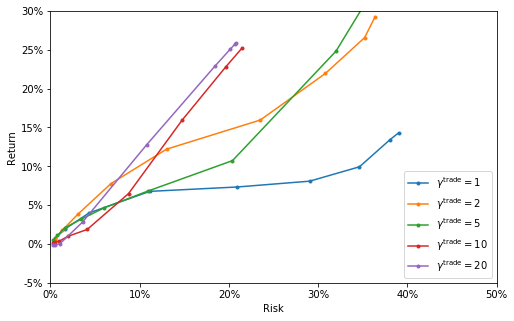

In [8]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,50])
plt.ylim([-5,30])

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier.png')

# SPO fine Search 

In [9]:
policies={}
gamma_risks_fine=gamma_risks_coarse
gamma_tcosts_fine=[4,5,6,7,8]
for gamma_risk in gamma_risks_fine:
    for gamma_tcost in gamma_tcosts_fine : 
        policies[(gamma_risk, gamma_tcost)] = \
      cp.SinglePeriodOpt(return_estimate, [gamma_risk*risk_model,gamma_tcost*optimization_tcost,optimization_hcost], 
                                [cp.LeverageLimit(3)])

import warnings
warnings.filterwarnings('ignore')
results.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,end_time=end_t,
                                              policies=policies.values(), parallel=True))))

In [10]:
result_df_fine=pd.DataFrame()
for k in results:
    if k[0] in gamma_risks_fine and k[1] in list(gamma_tcosts_fine):
        result_df_fine.loc[k[0], k[1]] = results[k]
        
result_df_fine=result_df_fine.loc[sorted(result_df_fine.index),sorted(result_df_fine.columns)]

[37.449718771332357, 33.254147646471658, 22.517439558323577, 13.199270075288755, 7.547916709068244, 4.1008542816540867, 1.9174973505664159, 0.91999342535096995, 0.38355088356740336] [32.79388719157038, 24.60106269883896, 15.848340587478926, 9.870818267828597, 6.190779120984915, 4.546622115473693, 2.6537170739272695, 1.3279074102863875, 0.524061214715224]
[36.482056402463172, 32.0022276995198, 20.404496715845191, 10.932081570215646, 6.0311576365058244, 3.4592485774604218, 1.6417447045920353, 0.78956046838163607, 0.34448005740695059] [33.28959714347796, 24.83600950713148, 10.733476314656082, 6.812572447778713, 4.656676836595719, 3.1921974076841004, 2.0899385570934483, 1.1016539334727546, 0.4538993163035798]
[33.879930745872826, 28.893579664475297, 18.628253744511166, 9.8000670222475144, 5.0202822083119898, 2.9499657229310134, 1.451364510946451, 0.70213818423049568, 0.31337217512982385] [30.407235039834145, 22.67230552982853, 9.30204142777468, 4.882764257156766, 3.748991630714513, 2.24071

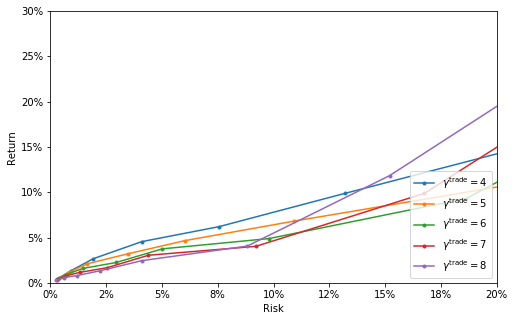

In [20]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df_fine.columns[:]:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df_fine[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df_fine[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier_fine.png')

# SPO Pareto search 

In [12]:
results_pareto={}

In [13]:
policies={}
#gamma_risks_pareto=[int(round(el)) if el>1 else el for el in np.logspace(-1,3,17)]
gamma_risks_pareto=[0.1, 0.17782, 0.31624, 0.562, 1.0, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000]
gamma_tcosts_pareto=[5.5,6,6.5,7,7.5,8]
gamma_holdings=[.1,1.,10.,100.,1000.]
for gamma_risk in gamma_risks_pareto:
    for gamma_tcost in gamma_tcosts_pareto : 
        for gamma_holding in gamma_holdings:
            policies[(gamma_risk, gamma_tcost, gamma_holding)] = \
          cp.SinglePeriodOpt(return_estimate, [gamma_risk*risk_model,gamma_tcost*optimization_tcost,\
                                       gamma_holding*optimization_hcost], 
                                [cp.LeverageLimit(3)])

import warnings
warnings.filterwarnings('ignore')
results_pareto.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,end_time=end_t,
                                              policies=policies.values(), parallel=True))))

In [14]:
table=pd.DataFrame()
table[r'$\gamma^\mathrm{risk}$']=[el[0] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{trade}$']=[el[1] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{hold}$']=['%g'%el[2] for el in results_pareto.keys()]
table['Return']=[(results_pareto[k].excess_returns.mean()*100*250) for k in results_pareto.keys()]
table['Risk']=[(results_pareto[k].excess_returns.std()*100*np.sqrt(250)) for k in results_pareto.keys()]
table = table.sort_values('Risk', ascending=False).reset_index()
del table['index']
is_pareto = lambda i: table.loc[i,'Return']>=max(table.ix[i:].Return)
table['is_pareto'] = [is_pareto(i) for i in range(len(table))]
#table.to_csv(datadir+'spo_pareto_results.csv', float_format='%g')

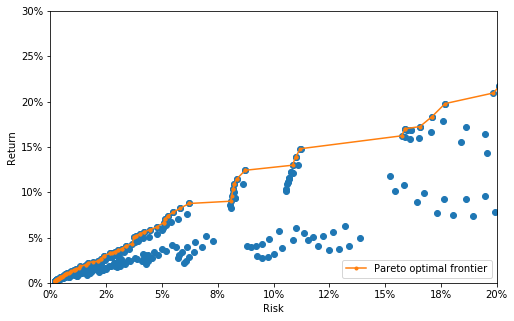

In [15]:
plt.figure(figsize=(8,5))
plt.scatter(table.Risk.values,table.Return.values)
plt.plot(table[table.is_pareto].Risk,table[table.is_pareto].Return, 'C1.-', label='Pareto optimal frontier')
plt.legend( loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_pareto.png')

In [16]:
xlim=20
ylim=30
table=table[table.is_pareto]
table=table[table.Risk <= xlim]
table=table[table.Return <= ylim]
del table['is_pareto']
table.Risk=table.Risk.apply(lambda x: '%.2f%%'%x)
table.Return=table.Return.apply(lambda x: '%.2f%%'%x)
print(table.iloc[::-1].to_latex(float_format='%.2f', escape=False, index=False).replace('%',r'\%'))

\begin{tabular}{rrlll}
\toprule
 $\gamma^\mathrm{risk}$ &  $\gamma^\mathrm{trade}$ & $\gamma^\mathrm{hold}$ &  Return &    Risk \\
\midrule
                1000.00 &                      8.0 &                    100 &   0.17\% &   0.22\% \\
                1000.00 &                      7.5 &                    100 &   0.18\% &   0.22\% \\
                1000.00 &                      7.0 &                    100 &   0.20\% &   0.22\% \\
                1000.00 &                      6.5 &                    100 &   0.22\% &   0.22\% \\
                1000.00 &                      6.0 &                    100 &   0.24\% &   0.23\% \\
                1000.00 &                      6.0 &                   1000 &   0.24\% &   0.23\% \\
                1000.00 &                      5.5 &                   1000 &   0.26\% &   0.23\% \\
                1000.00 &                      5.5 &                    100 &   0.26\% &   0.23\% \\
                1000.00 &                      7.5 &

In [21]:
table

,$\gamma^\mathrm{risk}$,$\gamma^\mathrm{trade}$,$\gamma^\mathrm{hold}$,Return,Risk
116,0.562,8.0,10,20.95%,19.86%
126,1.000,5.5,1000,19.78%,17.69%
130,1.000,6.0,1000,18.33%,17.10%
131,1.000,6.0,100,18.33%,17.10%
135,1.000,6.5,100,17.24%,16.55%
143,1.000,8.0,1000,17.01%,15.89%
144,1.000,8.0,100,17.01%,15.89%
147,1.000,8.0,10,16.22%,15.74%
162,2.000,5.5,1000,14.80%,11.21%
165,2.000,6.0,1000,13.91%,10.99%
